Imports

In [21]:
# imports
import numpy as np
import random
import torch
import torch.optim as optim
from utils import get_input_layer_2 as input
import game.flappyNoGraphics as Game
import game.wrapped_flappy_bird as GameVisual
from collections import deque
import pickle

Create the agent's neural net.

Use unactivated output to get unclipped q-value.

In [3]:
# define the neural net of the agent

import torch
import torch.nn as nn
import torch.optim as optim

class Network(nn.Module):
    def __init__(self, lr):
        super(Network, self).__init__()

        self.n_actions = 2
        self.hid_1 = 128
        self.hid_2 = 128
        self.hid_3 = 128
        self.inputs = 7 * 4
        self.model = nn.Sequential(
            nn.Linear(self.inputs, self.hid_1),
            nn.ReLU(),
            nn.Linear(self.hid_1, self.hid_2),
            nn.ReLU(),
            nn.Linear(self.hid_2, self.hid_3),
            nn.ReLU(),
            nn.Linear(self.hid_3, self.n_actions),
        )

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.SmoothL1Loss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, x):
        output = self.model(x.type(torch.FloatTensor).to(self.device))
        return output

In [4]:
# create a class to manage the state. Each state is a stack of 4 "frame" of the game
# which provides the agent on information of the bird's movement.

from collections import deque
import torch
from utils import get_input_layer_2 as input
import numpy as np

class StateManager(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)
        starting_state = [0, 0, 0, 0, 0, 0, 0]
        for _ in range(capacity):
            self.memory.append(starting_state)

    def push(self, game):
        """Save a frame, 
            returns tensor of flattened state frames
        """
        state_frame = input(game)
        self.memory.popleft()
        self.memory.append(state_frame)
        tensor_list = []
        for i in range(4):
            tensor_list.append(self.memory[i])
        return np.array(tensor_list).flatten()
    
    def get(self):
        # return np array of state frames
        tensor_list = []
        for i in range(4):
            tensor_list.append(self.memory[i])
        return np.array(tensor_list).flatten()

In [19]:
# create the class for the agent.

class Agent(object):
    def __init__(self):
        """
        Porperties:
            gamma (float): Future reward discount rate.
            epsilon (float): Probability for choosing random policy.
            epsilon_decay (float): Rate at which epsilon decays toward zero.
            learning_rate (float): Learning rate for Adam optimizer.

        Returns:
            Agent
        """
        # constant parameters
        self.gamma = 0.95
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.996
        self.lr = 0.00005
        self.batch_size = 64
        self.max_mem_size = 10000
        # self.input_dims = 7 * 4

        #variable parameters
        self.epsilon = 0.01
        self.mem_cntr = 0
        self.mem_cntr_successful = 0

        # initializing memory
        self.memory = deque(maxlen=self.max_mem_size)
        self.memory_successful = deque(maxlen=1000)
        self.episodic_memory = []

        #initialize networks
        self.network = Network(self.lr)

    def save_experience(self):
        with open('Models/DQL/experience.pickle', 'wb') as handle:
            pickle.dump(self.memory, handle)
        with open('Models/DQL/experience_successful.pickle', 'wb') as handle:
            pickle.dump(self.memory_successful, handle)

    def load_experience(self):
        with open('Models/DQL/experience.pickle', 'rb') as handle:
            self.memory = pickle.load(handle)
        with open('Models/DQL/experience_successful.pickle', 'rb') as handle:
            self.memory_successful = pickle.load(handle)

    def getMemory(self):
        return self.memory

    def nextEpisode(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def getepsilon(self):
        return self.epsilon

    def remember(self, state, action, reward, next_state, game_over, score, next_reward):
        if (self.mem_cntr >= self.max_mem_size - 2):
            for i in range(self.max_mem_size - 3000):
                self.memory.popleft()
            self.mem_cntr = len(self.memory) - 1

        memory = [state, action, reward, next_state, game_over, score, next_reward]
        self.memory.append(memory)

        self.mem_cntr += 1

    def remember_successful(self, state, action, reward, next_state, game_over, score, next_reward):
        if (self.mem_cntr_successful >= 1000 - 20):
            for i in range(1000 - 500):
                self.memory_successful.popleft()
            self.mem_cntr_successful = len(self.memory_successful) - 1

        memory = [state, action, reward, next_state, game_over, score, next_reward]
        self.memory_successful.append(memory)

        self.mem_cntr_successful += 1

    def select_action(self, state):
        if np.random.rand() <= self.epsilon:
            # exploration

            # 2 in 30 = averages about 1 press every 0.5 seconds which is in the ballpark of whats required to play the game. 
            # Gives bot best start possible (as it actually has a chance of making it through the first block!)
            # in flappy bird a flap changes the gamestate a lot more than a no-flap.
            determiner = np.random.randint(0, 30);
            if (determiner <= 2):
                return 1
            return 0
        else:
            # exploitation, select epsilon-greedy action.
                state_tensor = torch.tensor([state]).to(self.network.device, dtype=torch.int32)
                action = torch.argmax(self.network.forward(state_tensor)).item()
                
        return action
    
    def updateEpsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

    def learn(self):
        """
        learn from a random batch of experiences
        """
        if self.mem_cntr < self.batch_size:
            return
        
        self.network.optimizer.zero_grad()
        max_mem = min(self.mem_cntr, self.max_mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        batch_index = np.arange(self.batch_size, dtype=np.int32)

        # memory = [state, action, reward, next_state, game_over, score, next_reward]
        state_batch = torch.tensor([self.memory[i][0] for i in batch]).to(self.network.device, dtype=torch.float32)
        action_batch = torch.tensor([self.memory[i][1] for i in batch])
        reward_batch = torch.tensor([self.memory[i][2] for i in batch]).to(self.network.device, dtype=torch.float32)
        new_state_batch = torch.tensor([self.memory[i][3] for i in batch]).to(self.network.device, dtype=torch.float32)
        game_over_batch = torch.tensor([self.memory[i][4] for i in batch]).to(self.network.device, dtype=torch.bool)

        #estimate q(s,a) and q(s',a').
        q_current = self.network.forward(state_batch)[batch_index, action_batch]
        q_next = self.network.forward(new_state_batch)
        q_next[game_over_batch] = 0.0
        # q(st,at) = r + gamma * max(q(s',a')
        q_target = reward_batch + self.gamma * torch.max(q_next, dim=1)[0]

        # smoothl1 loss and back-propagation
        loss = self.network.loss(q_target, q_current).to(self.network.device)
        loss.backward()
        #prevent exploding gradient
        torch.nn.utils.clip_grad_value_(self.network.parameters(), 100)
        self.network.optimizer.step()

    def learn_successful(self):
        """
        learn from the set of experience that the agent was successful in. 
        Incentivises the agent to 
        """
        if self.mem_cntr_successful < self.batch_size:
            return
        
        # print("learning successful")
        self.network.optimizer.zero_grad()
        max_mem = min(self.mem_cntr_successful, self.max_mem_size)
        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        batch_index = np.arange(self.batch_size, dtype=np.int32)

        # memory = [state, action, reward, next_state, game_over, score]
        state_batch = torch.tensor([self.memory[i][0] for i in batch]).to(self.network.device, dtype=torch.float32)
        action_batch = torch.tensor([self.memory[i][1] for i in batch])
        reward_batch = torch.tensor([self.memory[i][2] for i in batch]).to(self.network.device, dtype=torch.float32)
        new_state_batch = torch.tensor([self.memory[i][3] for i in batch]).to(self.network.device, dtype=torch.float32)
        game_over_batch = torch.tensor([self.memory[i][4] for i in batch]).to(self.network.device, dtype=torch.bool)
        #estimate q(s,a) and q(s',a').
        q_current = self.network.forward(state_batch)[batch_index, action_batch]
        q_next = self.network.forward(new_state_batch)
        q_next[game_over_batch] = 0.0
        # q(st,at) = r + gamma * max(q(s',a')
        q_target = reward_batch + self.gamma * torch.max(q_next, dim=1)[0]
        
        # smoothl1 loss and back-propagation
        loss = self.network.loss(q_target, q_current).to(self.network.device)
        loss.backward()
        self.network.optimizer.step()

    def update_episodic_memory(self, state, action, reward, next_state, done, score, current_step):
        """appends to a temporary memory. The temporary memory is uploaded to the main memory
        once a game is complete.
        """
        self.episodic_memory.append([state, action, reward, next_state, done, score, 0])

In [8]:
#the trainer allows a human to play the game then upload the relevant data to the agent.
# increases the rate at which the agent initially learns.
import keyboard
import pickle

class Trainer(object):
    def __init__(self, agent):
        self.runs = 10
        self.agent = agent
        self.game = GameVisual.GameState()
        self.state_manager = StateManager(4)

    def play(self, runs=10):
        self.runs = runs
        self.agent.episodic_memory = []
        current_step = 0
        # for runs amount of games
        for i in range(self.runs):
            #initialize game
            self.game = GameVisual.GameState()
            self.state_manager = StateManager(4)
            state = self.state_manager.get()
            done = False
            score = 0
            # manually play the game
            while not done:
                if keyboard.is_pressed(" "):
                    action = 1
                    _, reward, _ = self.game.frame_step(True)
                else:
                    action = 0
                    _, reward, _ = self.game.frame_step(False)
                if (reward == -5):
                    done = True
                    final_score = score
                    reward = -5
                score += reward

                self.state_manager.push(self.game)
                
                #upload experience and train the agent on the human gameplay
                next_state = self.state_manager.get()
                self.agent.update_episodic_memory(state, action, reward, next_state, done, score, current_step)
                self.agent.learn()
                self.agent.learn_successful()
                current_step += 1
                state = next_state
            for frame in self.agent.episodic_memory:
                self.agent.remember(frame[0], frame[1], frame[2], frame[3], frame[4], frame[5], frame[6])
                self.agent.remember_successful(frame[0], frame[1], frame[2], frame[3], frame[4], frame[5], frame[6])


In [18]:
#main training loop
import matplotlib.pyplot as plt


def train():

    agent = Agent()
    scores, median_scores, eps_history, time_history, time_median = [], [], [], [], []
    n_games = 100000
    success_threshold = 15
    trainer = Trainer(agent)

    # trainer.play(10)
    # agent.save_experience()
    agent.load_experience()
    #learn from human experiences for a headstart
    #without this, the agent typically just default to a policy of only flapping or only doing nothing
    for i in range(100):
        agent.learn()

    # for n_games amount of games
    for i in range(n_games):
        #initialize game
        game = Game.GameState()
        if (keyboard.is_pressed("p")):
            game = GameVisual.GameState()
        score = 0
        game_over = False
        state_manager = StateManager(4)
        state = state_manager.get()
        done = False
        # state, action, reward, next_state, done, score
        agent.episodic_memory = []
        current_step = 0
        #while the game is not complete
        while not done:
            #select an action
            action = agent.select_action(state)
            _, reward, _ = game.frame_step(action)
            #calculate the state
            state_manager.push(game)
            next_state = state_manager.get()
            if (reward == -5):
                done = True
                final_score = score
                reward = -5
            score += reward
            #remember the action taken
            # agent.remember(state, action, reward, next_state, done, score)
            agent.update_episodic_memory(state, action, reward, next_state, done, score, current_step)
            

            state = next_state
            current_step += 1
        #after each game, learn a random batch of experiences from memory
        #and also lean a batch of experiences that the bird was successful in.
        agent.learn()
        agent.learn_successful()

        agent.updateEpsilon()
        #upload memory to main memory
        eps_history.append(agent.epsilon)
        for frame in agent.episodic_memory:
            agent.remember(frame[0], frame[1], frame[2], frame[3], frame[4], frame[5], frame[6])
        # success_threshold is typically 10 greater than the median score.
        if (score > success_threshold):
            agent.remember_successful(frame[0], frame[1], frame[2], frame[3], frame[4], frame[5], frame[6])
        # agent.remember(state, action, reward, next_state, done, score)

        #calculate some statistics for evaluation
        median_score = np.median(scores[-100:])
        success_threshold = max(success_threshold, median_score + 10)
        scores.append(score)
        median_scores.append(median_score)
        time_history.append(current_step/30)
        median_t = np.median(time_history[-100:])
        time_median.append(median_t)
        if ((i % 100) == 0):
            print('episode: ', i,'score: %.2f' % score,
                    ' median score %.2f' % median_score, 'time %.2f' % (current_step/30),'median time %.2f' % (median_t) ,'epsilon %.2f' % agent.epsilon)
        if (keyboard.is_pressed("`")):
            break
    #save the final model
    torch.save(agent.network.state_dict(), 'Models/DQL/dqlmodel.pth')
    #plot.
    plt.plot(time_median)
    plt.show()

episode:  0 score: -9.20  median score nan time 1.67 median time 1.67 epsilon 0.01
episode:  100 score: 31.40  median score 10.20 time 2.27 median time 1.30 epsilon 0.01
episode:  200 score: 14.60  median score 14.60 time 1.67 median time 1.67 epsilon 0.01
episode:  300 score: 14.60  median score 14.60 time 1.67 median time 1.67 epsilon 0.01
episode:  400 score: 14.60  median score 14.60 time 1.67 median time 1.67 epsilon 0.01
episode:  500 score: 14.60  median score 14.60 time 1.67 median time 1.67 epsilon 0.01
episode:  600 score: 14.60  median score 14.60 time 1.67 median time 1.67 epsilon 0.01
episode:  700 score: 14.60  median score 14.60 time 1.67 median time 1.67 epsilon 0.01
episode:  800 score: 5.00  median score 14.60 time 1.67 median time 1.67 epsilon 0.01
episode:  900 score: 2.60  median score 14.60 time 1.67 median time 1.67 epsilon 0.01
episode:  1000 score: 0.60  median score 14.60 time 1.70 median time 1.67 epsilon 0.01
episode:  1100 score: 14.60  median score 14.60 t

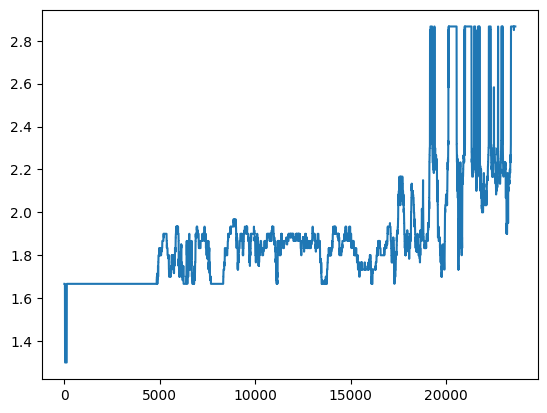

In [20]:
#run the DQL model training.

train()